**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

# NOTE

**If you have not looked at the [regular example notebooks](../2D), please do so first.**  
The notebooks in this folder provide further details about the inner workings of StarDist and might be useful if you want to apply it in a slightly different context.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

Using TensorFlow backend.


# Data

In [2]:
def show_image(img, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(2,4, figsize=(16,8))
    mid = [s//2 + 600 for s in img.shape[:2]]
    for a,t,u in zip(ax.ravel(),[1,2,4,8,16,32,64,128],[16,8,4,2,1,1,1,1]):
        sl = tuple(slice(c - s//t//2, c + s//t//2, u) for s,c in zip(img.shape[:2],mid))
        a.imshow(img[sl], **kwargs)
        a.axis('off')
    plt.tight_layout()
    plt.show()

Download example image in [SVS format](http://paulbourke.net/dataformats/svs/), which in this case can be read as a TIFF file.

In [3]:
datadir  = Path('data') / 'big'
filename = 'image.tif'
url      = 'https://pathology.cancerimagingarchive.net/download/SAR/C3L-00035-21.svs'

datadir.mkdir(parents=True, exist_ok=True)
if not (datadir/filename).exists():
    keras.utils.get_file(filename, url, cache_dir=str(datadir), cache_subdir='.')
None;

212926464/212920997 [==============================] - 21s 0us/step


In [4]:
img = imread(str(datadir/filename))
print(f"image of shape {img.shape} and dtype {img.dtype}")

image of shape (28175, 29879, 3) and dtype uint8


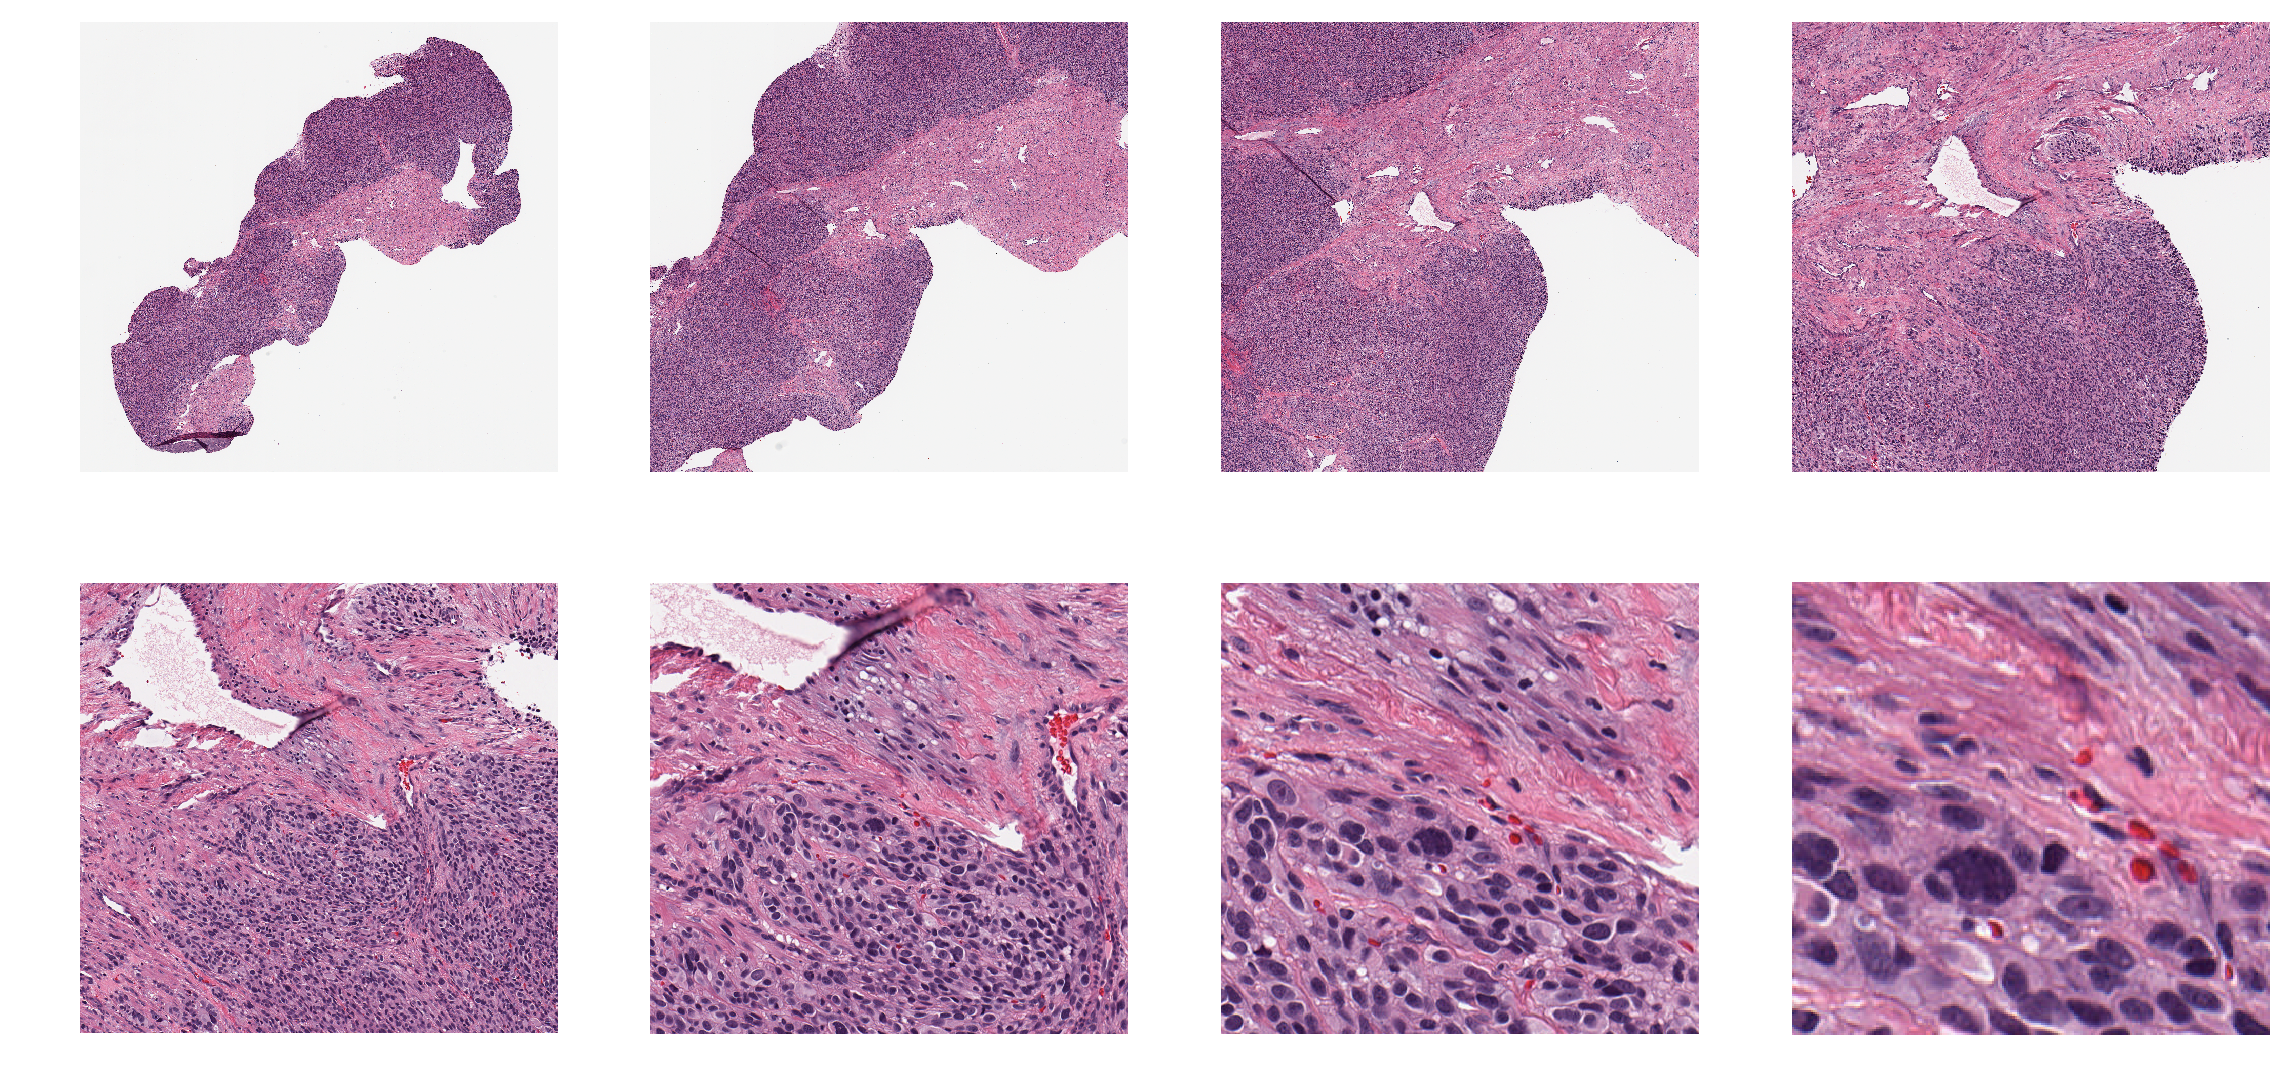

In [5]:
show_image(img)

# Prediction

## Model

Load pretrained model for [H&E stained](https://en.wikipedia.org/wiki/H%26E_stain) images.

In [6]:
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


## Image normalization

StarDist expects input images to be normalized or that a suitable `normalizer` is passed to `model.predict_instances`.  
Typically, you'd normalize an input image directly without the need for an additional `normalizer` (commented out):

In [7]:
# img = normalize(img, 1, 99.8)
# normalizer = None

However, this can be slow for large images, or even infeasible for images that do not fit in memory (e.g. via [Zarr](https://zarr.readthedocs.io), see below).  
Hence, we do not normalize the input image `img` and instead define a custom `normalizer`:

In [8]:
from csbdeep.data import Normalizer, normalize_mi_ma

class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

# mi, ma = np.percentile(img[::8], [1,99.8])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
mi, ma = 0, 255                                                   # use min and max dtype values (suitable here)
normalizer = MyNormalizer(mi, ma)

## Block-wise prediction

We could now run the prediction like this (commented out):

In [9]:
# labels, polys = model.predict_instances(img, normalizer=normalizer, n_tiles=(32,32,1))

This would break down the input image into 1024 overlapping _tiles_ to be processed individually by the CNN, but the subsequent non-maximum suppression step would be run on the entire image all at once. This can be prohibitive both in terms of memory and computation requirements.

Hence, we can use `model.predict_instances_big` instead, which will break up the input image into larger overlapping _blocks_, each of which is processed via `model.predict_instances`. Please see the documentation:

In [10]:
help(model.predict_instances_big)

Help on method predict_instances_big in module stardist.models.base:

predict_instances_big(img, axes, block_size, min_overlap, context=None, labels_out=None, labels_out_dtype=<class 'numpy.int32'>, show_progress=True, **kwargs) method of stardist.models.model2d.StarDist2D instance
    Predict instance segmentation from very large input images.
    
    Intended to be used when `predict_instances` cannot be used due to memory limitations.
    This function will break the input image into blocks and process them individually
    via `predict_instances` and assemble all the partial results. If used as intended, the result
    should be the same as if `predict_instances` was used directly on the whole image.
    
    **Important**: The crucial assumption is that all predicted object instances are smaller than
                   the provided `min_overlap`. Also, it must hold that: min_overlap + 2*context < block_size.
    
    Example
    -------
    >>> img.shape
    (20000, 20000)
    >>

Finally, we call `model.predict_instances_big` to run the block-wise prediction:

In [11]:
labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128,
                                            normalizer=normalizer, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 64/64 [15:29<00:00, 12.39s/it]


## Show & Save

Showing the predicted label image in the same way as the input image above:

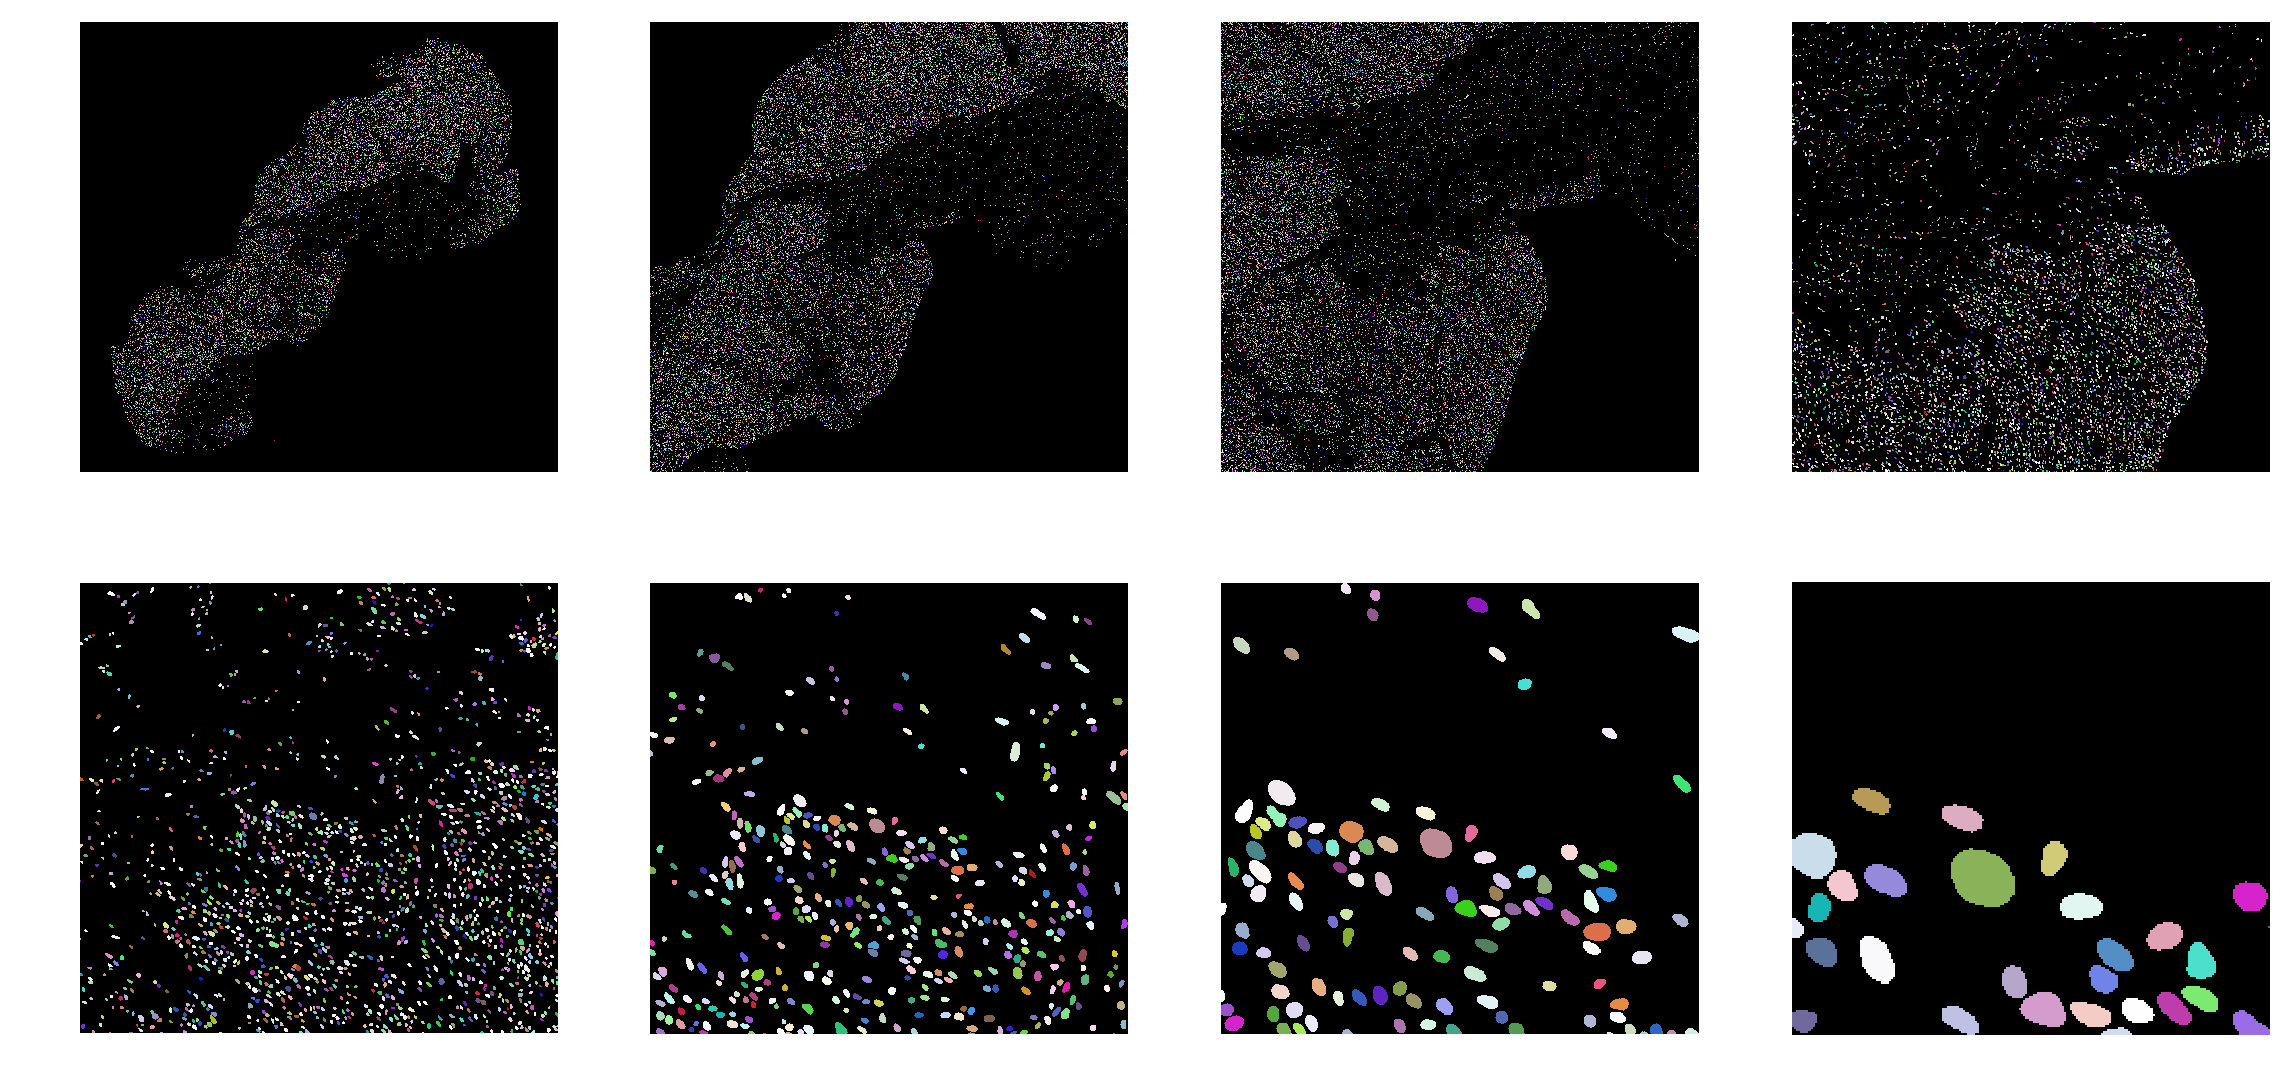

In [12]:
show_image(labels, cmap=cmap)

**Bonus:** Since label ids are consecutive within each block, they are quantized to the same color when using a colormap with few colors. This allows us to visualize the blocks that have been used during prediction (left). Prediction blocks are not visible when using a suitable colormap for label images (right):

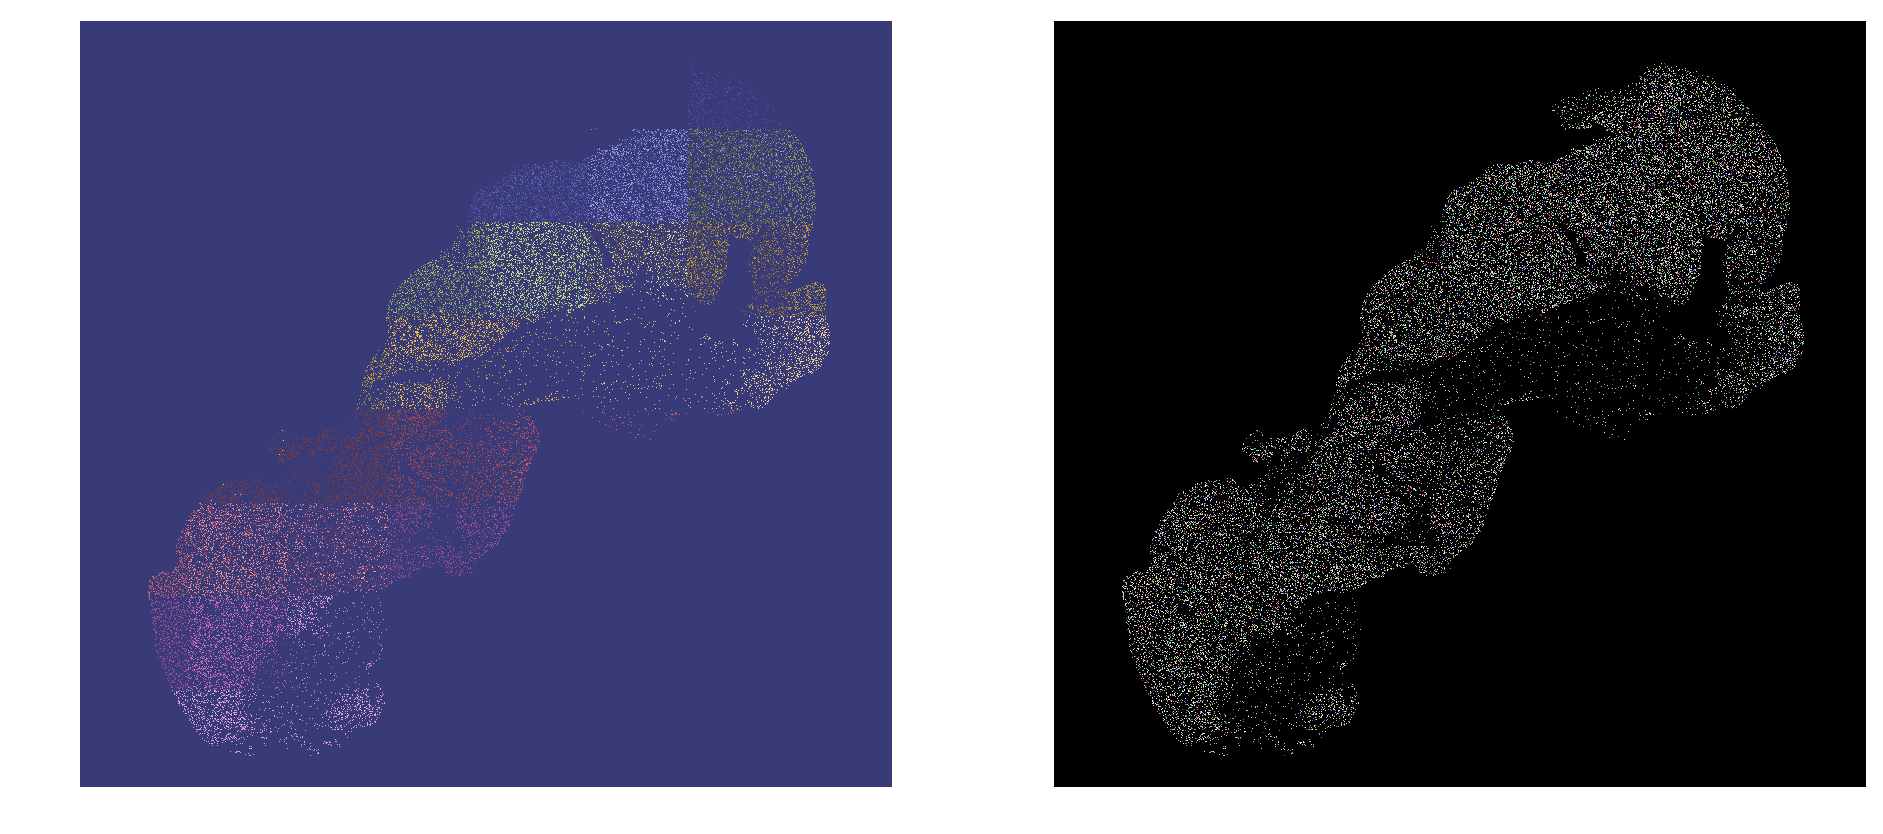

In [13]:
fig, (a,b) = plt.subplots(1,2, figsize=(16,16))
a.imshow(labels[::8,::8], cmap='tab20b')
b.imshow(labels[::8,::8], cmap=cmap)
a.axis('off'); b.axis('off');
None;

We can save the results to disk as label image and/or ImageJ ROIs. (Compression highly recommended.)

In [14]:
from zipfile import ZIP_DEFLATED

imsave(str(datadir/'labels.tif'), labels, compress=ZIP_DEFLATED)
export_imagej_rois(str(datadir/'labels_roi.zip'), polys['coord'], compression=ZIP_DEFLATED)

# Zarr instead of Numpy arrays for very large images

If your images are too large to be loaded all at once, you can use [Zarr](https://zarr.readthedocs.io) to store and process them.

In [15]:
import zarr

# for this demo: make a zarr array copy of img
zarr.save_array(str(datadir/'image.zarr'), img)

Load input image as read-only Zarr array:

In [16]:
img = zarr.open(str(datadir/'image.zarr'), mode='r')
img.info

Type               : zarr.core.Array
Data type          : uint8
Shape              : (28175, 29879, 3)
Chunk shape        : (1761, 1868, 1)
Order              : C
Read-only          : True
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 2525522475 (2.4G)
No. bytes stored   : 1119048423 (1.0G)
Storage ratio      : 2.3
Chunks initialized : 768/768

Define the output label image as an empty Zarr array:

In [17]:
labels = zarr.open(str(datadir/'labels.zarr'), mode='w', shape=img.shape[:2], chunks=img.chunks[:2], dtype=np.int32)
labels.info

Type               : zarr.core.Array
Data type          : int32
Shape              : (28175, 29879)
Chunk shape        : (1761, 1868)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 3367363300 (3.1G)
No. bytes stored   : 345
Storage ratio      : 9760473.3
Chunks initialized : 0/256

Run the block-wise prediction and pass `labels_out=labels` to write to the predefined Zarr array for the label image.  
(Note: You can alternatively pass `labels_out=False` if you don't need the label image.)

In [18]:
labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128,
                                            normalizer=normalizer, n_tiles=(4,4,1),
                                            labels_out=labels)

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 64/64 [15:39<00:00, 13.57s/it]


The label image is now populated:

In [19]:
labels.info

Type               : zarr.core.Array
Data type          : int32
Shape              : (28175, 29879)
Chunk shape        : (1761, 1868)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 3367363300 (3.1G)
No. bytes stored   : 101730974 (97.0M)
Storage ratio      : 33.1
Chunks initialized : 256/256